# Autocodificadores

<table align='left'>
<tr><td> <img src="../figures/autoencoder_schema.jpg"> </td></tr>
</table>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import OrderedDict

from PIL import Image
from IPython import display

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
x_train, y_train = torch.load('/data/datasets/MNIST/processed/training.pt')
x_test,  y_test  = torch.load('/data/datasets/MNIST/processed/test.pt')

In [3]:
print(x_train.shape, x_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## Treinando com pouquíssimos dados

In [4]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
else:
    n_train_samples = x_train.shape[0]
    n_test_samples  = x_test.shape[0]
xx_train = x_train[:n_train_samples].type(torch.FloatTensor) /255.
yy_train = y_train[:n_train_samples] 
xx_test  = x_test[:n_test_samples].type(torch.FloatTensor) / 255.
yy_test  = y_test[:n_test_samples]

In [5]:
xx_train.shape, xx_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
xx_train.type(),yy_train.type(), xx_test.type(), yy_test.type()

('torch.FloatTensor',
 'torch.LongTensor',
 'torch.FloatTensor',
 'torch.LongTensor')

## Cria a rede

<table align='left'>
<tr><td> <img src="../figures/autoencoder_1.png",width=600pt> </td></tr>
</table>

In [7]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super(MyAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(28*28, 512)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(512, 128)),
            ('relu2', nn.ReLU()),
            ('dense3', nn.Linear(128, 2))
        ]))
        
        self.decoder = nn.Sequential(OrderedDict([
            ('dense3', nn.Linear(2, 128)),
            ('relu2', nn.ReLU()),
            ('dense2', nn.Linear(128, 512)),
            ('relu1', nn.ReLU()),
            ('dense1', nn.Linear(512, 28*28))
        ]))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 28, 28)
        
        return x
    
model = MyAutoEncoder()
model

MyAutoEncoder (
  (encoder): Sequential (
    (dense1): Linear (784 -> 512)
    (relu1): ReLU ()
    (dense2): Linear (512 -> 128)
    (relu2): ReLU ()
    (dense3): Linear (128 -> 2)
  )
  (decoder): Sequential (
    (dense3): Linear (2 -> 128)
    (relu2): ReLU ()
    (dense2): Linear (128 -> 512)
    (relu1): ReLU ()
    (dense1): Linear (512 -> 784)
  )
)

## Cria o trainer

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)
savebest = ptt.ModelCheckpoint('../../models/auto_encoder_pt',reset=True, verbose=1)
trainer = ptt.DeepNetTrainer( 
                         model, 
                         criterion, 
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                         callbacks = [savebest, ptt.PrintCallback()]
                        )

## Treinamento

In [9]:
trainer.fit(20,xx_train, xx_train, valid_data=(xx_test,xx_test) ,batch_size=20)

Start training for 20 epochs
  1:   6.0s   T: 0.04526   V: 0.04089 best
  2:   6.0s   T: 0.04037   V: 0.03917 best
  3:   6.0s   T: 0.03904   V: 0.03885 best
  4:   6.0s   T: 0.03825   V: 0.03798 best
  5:   6.0s   T: 0.03779   V: 0.03799 
  6:   6.0s   T: 0.03734   V: 0.03752 best
  7:   6.0s   T: 0.03586   V: 0.03608 best
  8:   6.0s   T: 0.03551   V: 0.03590 best
  9:   6.0s   T: 0.03536   V: 0.03589 best
 10:   5.8s   T: 0.03520   V: 0.03580 best
 11:   5.9s   T: 0.03508   V: 0.03571 best
 12:   5.8s   T: 0.03499   V: 0.03576 
 13:   5.9s   T: 0.03489   V: 0.03567 best
 14:   5.9s   T: 0.03469   V: 0.03560 best
 15:   6.0s   T: 0.03464   V: 0.03560 
 16:   6.0s   T: 0.03462   V: 0.03560 best
 17:   6.0s   T: 0.03461   V: 0.03559 best
 18:   6.0s   T: 0.03459   V: 0.03559 best
 19:   6.0s   T: 0.03458   V: 0.03559 
 20:   6.0s   T: 0.03457   V: 0.03559 best
Best model was saved at epoch 20 with loss 0.03559: ../../models/auto_encoder_pt
Stop training at epoch: 20/20


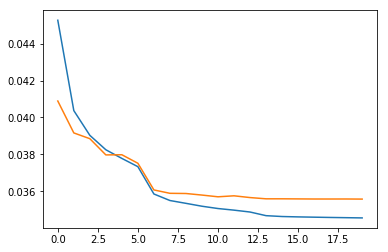

In [10]:
tra_loss = trainer.metrics['train']['losses']
val_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(tra_loss))
plt.plot(epochs, tra_loss, epochs, val_loss)

In [11]:
trainer.load_state('../../models/auto_encoder_pt')

In [12]:
yy_pred = trainer.predict(xx_test)

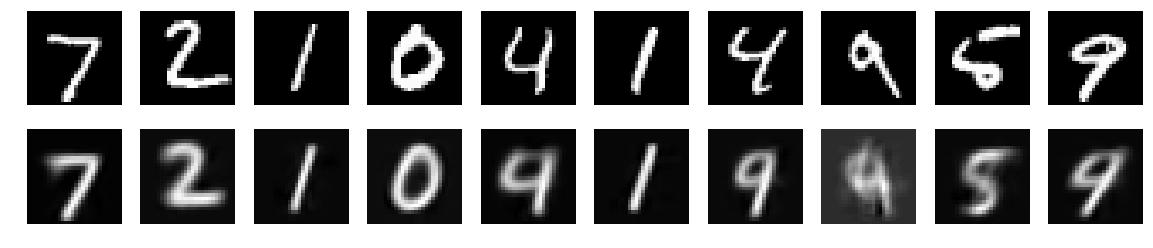

In [13]:
n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xx_test[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(yy_pred[i].cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens no plano 2D

In [16]:
xin = Variable(xx_train.view(-1, 28*28))
if use_gpu:
    xin = xin.cuda()
encoded = trainer.model.encoder(xin)
encoded_data = encoded.data.cpu().numpy()

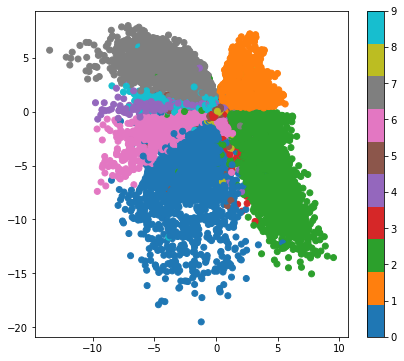

In [17]:
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10)
plt.colorbar();
plt.show()

## transformação na imagem ao percorrer uma linha no espaço 2D

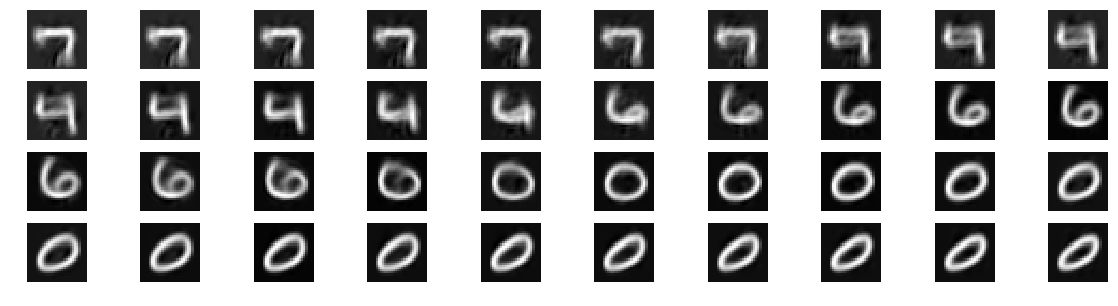

In [22]:
n = 40
x = np.linspace(-10.0,  0.0, n)
y = np.linspace(  5.0, -10.0, n)

data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

data_in = Variable(data)
if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decoder(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()